In [28]:
%pip install pandas numpy matplotlib seaborn scipy cvxpy openpyxl scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


BS - FIDR_PA - M
{'@TIME_PERIOD': '1985-01', '@OBS_VALUE': '7.42'}
{'@TIME_PERIOD': '2023-12', '@OBS_VALUE': '0.55'}


/var/folders/9x/p8jlzgy11cv4_f8srk_0w80w0000gn/T/ipykernel_30607/603798080.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  recentval = round(df[-1], 1)


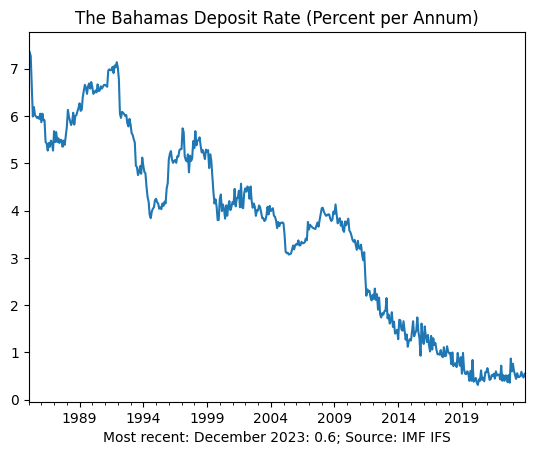

In [80]:
import requests # Python 3.6
import pandas as pd # pandas version 0.23

# The Bahamas

FREQUENCY = 'M' # 'M' for monthly, 'Q' for quarterly, 'A' for annual
COUNTRY = 'BS' # ISO country code
INDICATOR = 'FIDR_PA' # 'FIDR_PA' for Interest Rates, Deposit Interest

url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
key = f'CompactData/IFS/{FREQUENCY}.{COUNTRY}.{INDICATOR}'

# Navigate to series in API-returned JSON data
data = (requests.get(f'{url}{key}').json()
        ['CompactData']['DataSet']['Series'])

print(f"{COUNTRY} - {INDICATOR} - {FREQUENCY}")
print(data['Obs'][0]) # Print first observation
print(data['Obs'][-1]) # Print latest observation

# Create pandas dataframe from the observations
data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')]
             for obs in data['Obs']]

df = pd.DataFrame(data_list, columns=['date', 'value'])
df = df.set_index(pd.to_datetime(df['date']))['value'].astype('float')

# Save cleaned dataframe as a csv file
df.to_csv(f'data/{FREQUENCY}-{COUNTRY}-{INDICATOR}.csv', header=True)

# Title and text with recent value
title = 'The Bahamas Deposit Rate (Percent per Annum)'
recentdt = df.index[-1].strftime('%B %Y')
recentval = round(df[-1], 1)
recent = f'Most recent: {recentdt}: {recentval}'
source = 'Source: IMF IFS'

# Basic plot
plot = df.plot(title=title)
plot = plot.set_xlabel(f'{recent}; {source}')

In [71]:
# The Bahamas
TREATMENT_UNIT = 'BS'
# Antigua and Barbuda, Barbados, Belize, Dominica, Fiji, Grenada, Mauritius, Seychelles, Cayman Islands, Jamaica, Saint Kitts and Nevis, Saint Lucia, Saint Vincent and the Grenadines, British Virgin Islands, Trinidad and Tobago
CONTROL_UNITS = ['AG', 'BB', 'BZ', 'DM', 'FJ', 'GD', 'MU', 'SC', 'KY', 'JM', 'KN', 'LC', 'VC', 'VG', 'TT']
COUNTRIES = [TREATMENT_UNIT] + CONTROL_UNITS

# Deposits Interest Rate
OUTPUT = 'FIDR_PA'
# GDP, Inflation Rate, Treasury Bills, Central Bank Policy Rate, Savings Rate, Lending Rate
INPUTS = ['NGDP_R_XDC', 'PCPI_IX', 'FITB_PA', 'FPOLM_PA', 'FISR_PA', 'FILR_PA']
INDICATORS = [OUTPUT] + INPUTS

# IMF DATA API
URL = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
FREQUENCY = 'Q' # 'M' for monthly, 'Q' for quarterly, 'A' for annual

# # IMF OTHER API
# URLv1 = 'https://www.imf.org/external/datamapper/api/v1/'
# COUNTRY = 'BHS' # ISO country code
# INDICATOR = 'NGDP_RPCH' # 'NGDP_RPCH' for GDP Change; 'PCPIEPCH' for CPI Change

# print(f"Getting data for {COUNTRY} - {INDICATOR}")

# key = f'{INDICATOR}/{COUNTRY}'

# # Make the request
# response = requests.get(f'{URLv1}{key}')

# if response.status_code != 200:
#     print(f"Failed to retrieve data for {country} - {indicator}; Response code: {response.status_code}")

# print(response.json())
# sys.exit(0)

data = {}
for country in COUNTRIES:
    data[country] = {}

    for indicator in INDICATORS:
        print(f"Getting data for {country} - {indicator}")

        key = f'CompactData/IFS/{FREQUENCY}.{country}.{indicator}'

        # Make the request
        response = requests.get(f'{URL}{key}')

        if response.status_code != 200:
            print(f"Failed to retrieve data for {country} - {indicator}; Response code: {response.status_code}")
            continue

        try:
            imf_data = response.json()['CompactData']['DataSet']['Series']
        except KeyError as e:
            print(f"Failed to retrieve data for {country} - {indicator}; KeyError: ", e)
            continue
        except Exception as e:
            print(f"Failed to retrieve data for {country} - {indicator}; Error: ", e)
            continue

        # print(imf_data['Obs'][0]) # Print first observation
        # print(imf_data['Obs'][-1]) # Print latest observation

        # Create pandas dataframe from the observations
        data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')] for obs in imf_data['Obs']]

        df = pd.DataFrame(data_list, columns=['date', 'value'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df = df.set_index(pd.to_datetime(df['date']))
        # df = pd.DataFrame(data_list, columns=['date', 'value'])
        # df = df.set_index(pd.to_datetime(df['date']))['value'].astype('float')

        # Calculate the percentage change
        df['percent_change'] = df['value'].pct_change() * 100

        # Save cleaned up dataframe as a csv file
        # print(df)
        df.to_csv(f'data/{country}-{indicator}-{FREQUENCY}.csv', header=True)

        # Store the percentage change DataFrame in the dictionary
        data[country][indicator] = df

        print(f"Data and percentage changes for {country} - {indicator} retrieved and saved.")

# print(data)

# # Title and text with recent value
# title = 'The Bahamas Deposit Rate (Percent per Annum)'
# recentdt = df.index[-1].strftime('%B %Y')
# recentval = round(df[-1], 1)
# recent = f'Most recent: {recentdt}: {recentval}'
# source = 'Source: IMF IFS'

# # Basic plot
# plot = df.plot(title=title)
# plot = plot.set_xlabel(f'{recent}; {source}')

Getting data for BS - FIDR_PA
Data and percentage changes for BS - FIDR_PA retrieved and saved.
Getting data for BS - NGDP_R_XDC
Data and percentage changes for BS - NGDP_R_XDC retrieved and saved.
Getting data for BS - PCPI_IX
Data and percentage changes for BS - PCPI_IX retrieved and saved.
Getting data for BS - FITB_PA
Data and percentage changes for BS - FITB_PA retrieved and saved.
Getting data for BS - FPOLM_PA
Data and percentage changes for BS - FPOLM_PA retrieved and saved.
Getting data for BS - FISR_PA
Data and percentage changes for BS - FISR_PA retrieved and saved.
Getting data for BS - FILR_PA
Data and percentage changes for BS - FILR_PA retrieved and saved.
Getting data for AG - FIDR_PA
Data and percentage changes for AG - FIDR_PA retrieved and saved.
Getting data for AG - NGDP_R_XDC
Data and percentage changes for AG - NGDP_R_XDC retrieved and saved.
Getting data for AG - PCPI_IX
Data and percentage changes for AG - PCPI_IX retrieved and saved.
Getting data for AG - FITB

/var/folders/9x/p8jlzgy11cv4_f8srk_0w80w0000gn/T/ipykernel_30607/2956172329.py:75: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['percent_change'] = df['value'].pct_change() * 100


Data and percentage changes for FJ - FPOLM_PA retrieved and saved.
Getting data for FJ - FISR_PA
Data and percentage changes for FJ - FISR_PA retrieved and saved.
Getting data for FJ - FILR_PA
Data and percentage changes for FJ - FILR_PA retrieved and saved.
Getting data for GD - FIDR_PA
Data and percentage changes for GD - FIDR_PA retrieved and saved.
Getting data for GD - NGDP_R_XDC
Data and percentage changes for GD - NGDP_R_XDC retrieved and saved.
Getting data for GD - PCPI_IX
Data and percentage changes for GD - PCPI_IX retrieved and saved.
Getting data for GD - FITB_PA
Data and percentage changes for GD - FITB_PA retrieved and saved.
Getting data for GD - FPOLM_PA
Failed to retrieve data for GD - FPOLM_PA; KeyError:  'Series'
Getting data for GD - FISR_PA
Data and percentage changes for GD - FISR_PA retrieved and saved.
Getting data for GD - FILR_PA
Failed to retrieve data for GD - FILR_PA; Error:  Expecting value: line 1 column 1 (char 0)
Getting data for MU - FIDR_PA
Failed to

In [78]:
for key, value in data.items():
    print(key)
    for key, value in value.items():
        print(key)
    print(")

BS
FIDR_PA
NGDP_R_XDC
PCPI_IX
FITB_PA
FPOLM_PA
FISR_PA
FILR_PA

AG
FIDR_PA
NGDP_R_XDC
PCPI_IX
FISR_PA
FILR_PA

BB
FIDR_PA
PCPI_IX
FITB_PA
FISR_PA
FILR_PA

BZ
FIDR_PA
FPOLM_PA
FISR_PA
FILR_PA

DM
FIDR_PA
NGDP_R_XDC
PCPI_IX
FITB_PA
FISR_PA
FILR_PA

FJ
FITB_PA
FPOLM_PA
FISR_PA
FILR_PA

GD
FIDR_PA
NGDP_R_XDC
PCPI_IX
FITB_PA
FISR_PA

MU
NGDP_R_XDC
PCPI_IX
FITB_PA
FPOLM_PA
FISR_PA
FILR_PA

SC
FIDR_PA
NGDP_R_XDC
PCPI_IX
FITB_PA
FILR_PA

KY
NGDP_R_XDC
PCPI_IX

JM
FIDR_PA
NGDP_R_XDC
FPOLM_PA
FISR_PA
FILR_PA

KN
FIDR_PA
NGDP_R_XDC
PCPI_IX
FITB_PA
FISR_PA
FILR_PA

LC
PCPI_IX
FITB_PA
FISR_PA
FILR_PA

VC
FIDR_PA
NGDP_R_XDC
PCPI_IX
FITB_PA

VG

TT
FIDR_PA
NGDP_R_XDC
PCPI_IX
FISR_PA
FILR_PA



In [79]:
# EXAMPLE CODE IMF DATA API

# import pandas as pd          # pandas version 0.23

# baseyr = data['@BASE_YEAR']  # Save the base year

# # Create pandas dataframe from the observations
# data_list = [[obs.get('@TIME_PERIOD'), obs.get('@OBS_VALUE')]
#              for obs in data['Obs']]

# df = pd.DataFrame(data_list, columns=['date', 'value'])

# df = df.set_index(pd.to_datetime(df['date']))['value'].astype('float')

# # Save cleaned dataframe as a csv file
# df.to_csv('data/UK_import_price_index.csv', header=True)

# # Title and text with recent value
# title = f'U.K. Import Prices (index, {baseyr})'
# recentdt = df.index[-1].strftime('%B %Y')
# recentval = round(df[-1], 1)
# recent = f'Most recent: {recentdt}: {recentval}'
# source = 'Source: IMF IFS'

# # Basic plot
# plot = df.plot(title=title, colormap='Set1')
# plot = plot.set_xlabel(f'{recent}; {source}')